## Problem Set #3
### MACSS 30100, Dr. Evans
### Xi Chen

In [1]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')
%matplotlib notebook

income = np.loadtxt('incomes.txt')

## Q1. (a)

<IPython.core.display.Javascript object>


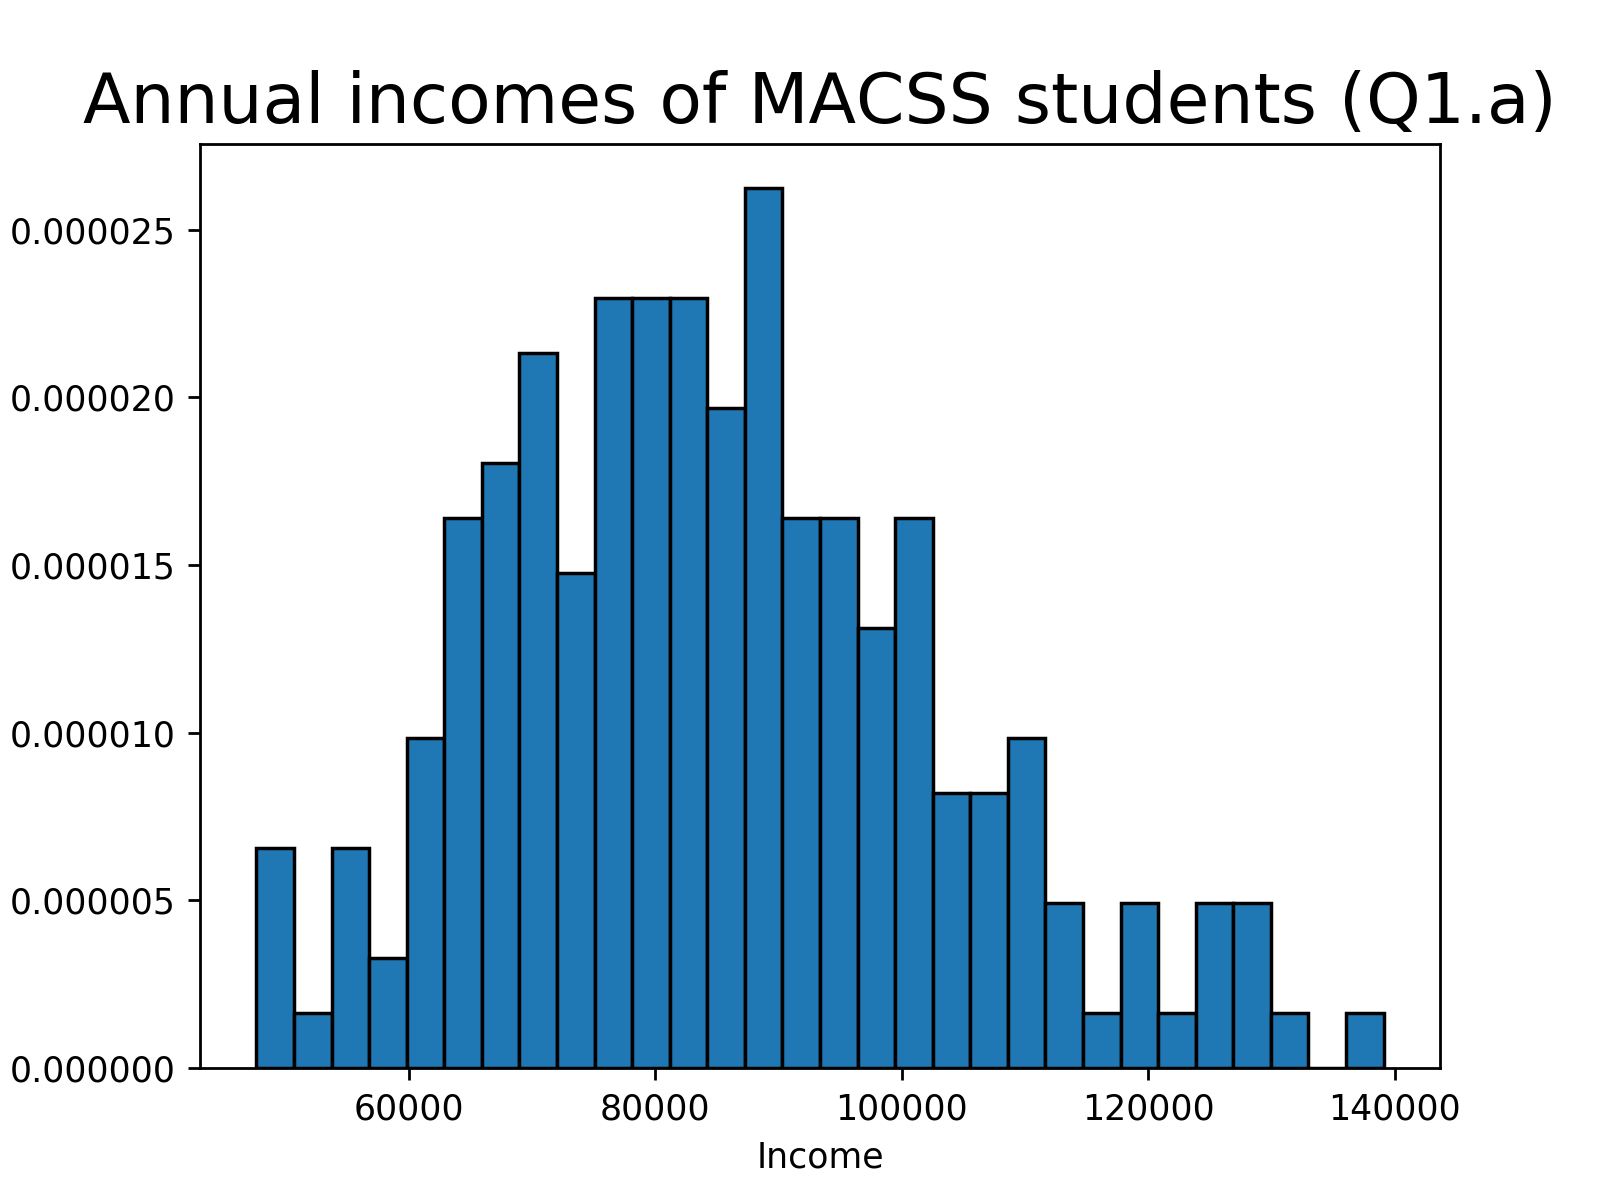

In [2]:
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Annual incomes of MACSS students (Q1.a)', fontsize=20)
plt.xlabel('Income')
plt.ylabel('Density')
plt.show()

## Q1. (b)

In [3]:
# Define function that generates values of a Lognormal PDF
def lognorm_pdf(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the log normal pdf with mean mu and standard
    deviation sigma. 
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION: 
    lognorm_pdf_vals = (N,) vector, lognormal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: lognorm_pdf_vals
    --------------------------------------------------------------------
    '''
    
    lognorm_pdf_vals = (1/(xvals * sigma * np.sqrt(2 * np.pi)) *\
                        np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2)))
    
    return lognorm_pdf_vals

Now let's define a criterion function that takes as inputs the parameters and the estimator for the weighting matrix $\hat{W}$.

In [4]:
def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), standard deviation(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of income data
    std_data  = scalar > 0, variance of income data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, std_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data


def model_moments(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), standard devation(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        lognorm_pdf()
        xfx()
        x2fx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_model = scalar, mean value of income from model
    m_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the mean of the distribution
    var_model  = scalar > 0, variance of income from model
    v_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the variance of the distribution
    std_model  = scalar, standard deviation of income
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_model, std_model
    --------------------------------------------------------------------
    '''
    xfx = lambda x: x * lognorm_pdf(x, mu, sigma)
    (mean_model, m_m_err) = intgr.quad(xfx, 1000, 150000)
    x2fx = lambda x: ((x - mean_model) ** 2) * lognorm_pdf(x, mu, sigma) 
    (var_model, v_m_err) = intgr.quad(x2fx, 1000, 150000)
    std_model = np.sqrt(var_model)
    
    return mean_model, std_model


def err_vec(xvals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    std_data   = scalar > 0, standard deviation of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    std_model  = scalar > 0, standard deviation from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [std_model]])
    
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 2 tuple, (xvals, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

Perform the GMM estimation with the identity matrix as the estimate for the optimal weighting matrix $W = I$.

In [5]:
mu_init = 10
sig_init = 0.3
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (income, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1 =', mu_GMM1, ' sig_GMM1 =', sig_GMM1)

mu_GMM1 = 11.3369093491  sig_GMM1 = 0.213027124606


Plot the estimated lognormal PDF against the histogram from part (a) 

<IPython.core.display.Javascript object>


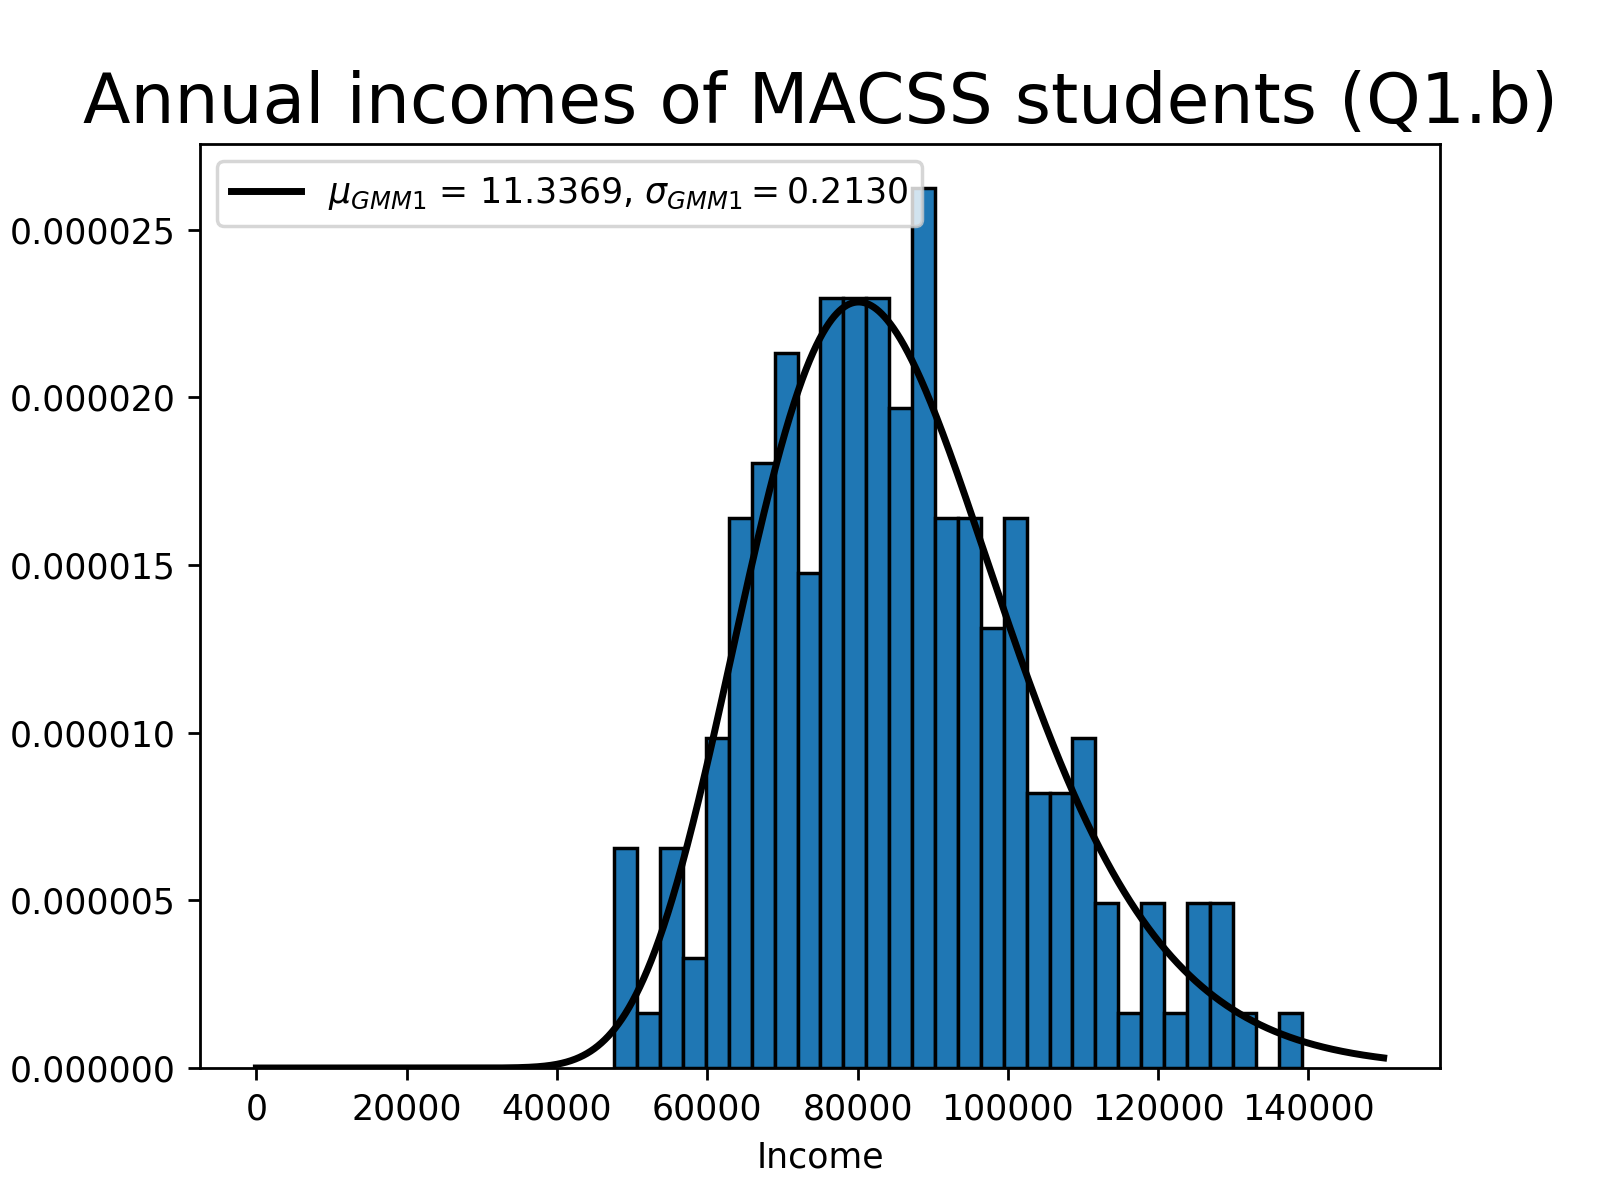

In [6]:
# Plot the histogram of the data
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Annual incomes of MACSS students (Q1.b)', fontsize=20)
plt.xlabel('Income')
plt.ylabel('Density')

# Plot the estimated GMM PDF
dist_pts = np.linspace(1e-10, 150000, 10000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1),linewidth=2, color='k', 
         label='$\mu_{GMM1}$ = 11.3369, $\sigma_{GMM1} = 0.2130 $')
plt.legend(loc='upper left')

Report the value of GMM criterion function at the estimated parameter values

In [7]:
params_GMM = np.array([mu_GMM1, sig_GMM1])
criterion_val = criterion(params_GMM,*gmm_args)
print("The value of the criterion function is {}.".format(criterion_val[0][0]))

The value of the criterion function is 1.1061213081504956e-12.


Report and compare the two data moments against the two model moments at the estimated parameter values

In [8]:
mean_data, var_data = data_moments(income)
mean_model, var_model = model_moments(mu_GMM1, sig_GMM1)
err1 = err_vec(income, mu_GMM1, sig_GMM1, False).reshape(2,)
print('Mean of points =', round(mean_data, 4), ', Standard deviation of points =', round(var_data, 4))
print('Mean of model  =', round(mean_model,4), ', Standard deviation of model  =', round(var_model, 4))
print('Error vector=', err1)

Mean of points = 85276.8236 , Standard deviation of points = 17992.5421
Mean of model  = 85276.7453 , Standard deviation of model  = 17992.5329
Error vector= [ -9.18433670e-07  -5.12445999e-07]


Comments: 
From the above results, we can see that the two data moments are really close to the two model moments. 

## Q1. (c)

In [9]:
err1 = err_vec(income, mu_GMM1, sig_GMM1, False)
VCV2 = np.dot(err1, err1.T) / income.shape[0]
print(VCV2)
W_hat2 = lin.pinv(VCV2)  
print(W_hat2)

[[  4.21760203e-15   2.35323830e-15]
 [  2.35323830e-15   1.31300451e-15]]
[[  1.37885968e+14   7.69343665e+13]
 [  7.69343665e+13   4.29260268e+13]]


Report the estimates and criterion function value at these estimate

In [10]:
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (income, W_hat2)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results.x
print('mu_GMM2 =', mu_GMM2, ' sig_GMM2 =', sig_GMM2)

mu_GMM2 = 11.3369095764  sig_GMM2 = 0.213027515169


In [11]:
params_GMM = np.array([mu_GMM2, sig_GMM2])
criterion_val = criterion(params_GMM,*gmm_args)
print("The value of the criterion function is {}.".format(criterion_val[0][0]))

The value of the criterion function is 0.005994447716434204.


Plot the estimated lognormal PDF against the histogram from part (a) and the estimated PDF from part (b)

<IPython.core.display.Javascript object>


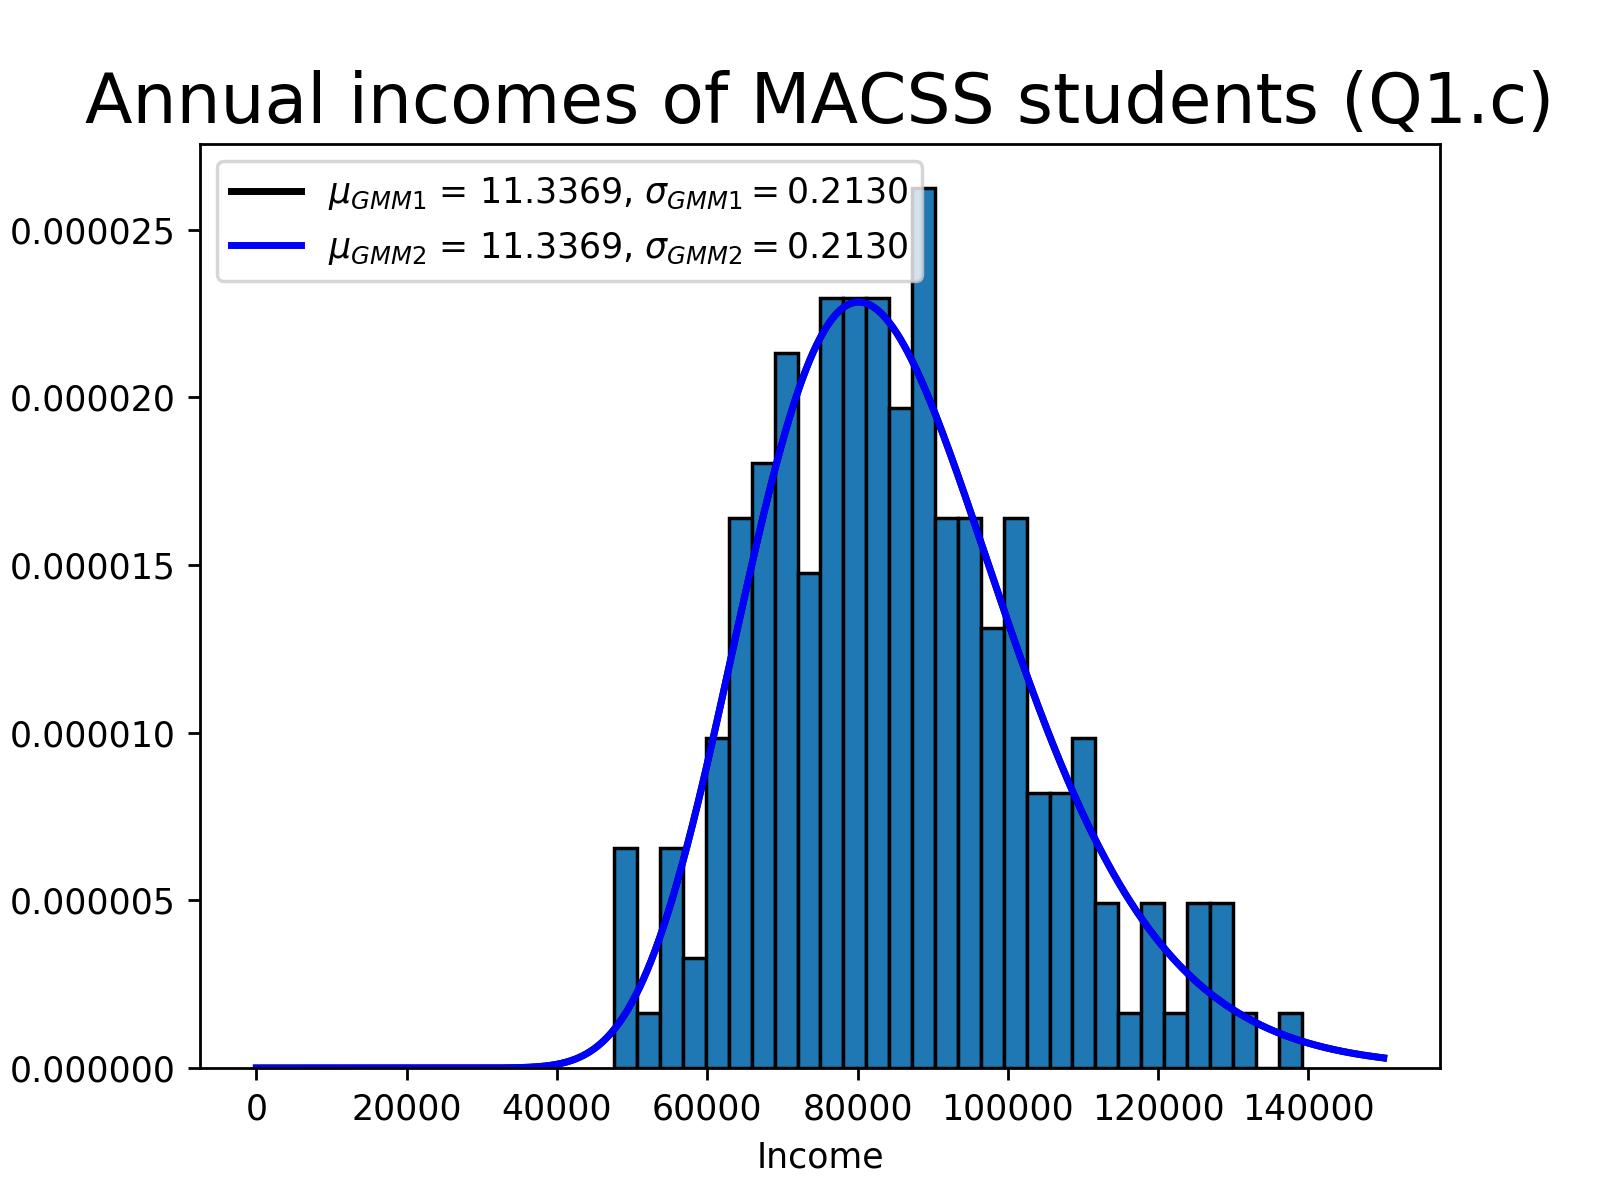

In [12]:
# Plot the histogram of the data
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Annual incomes of MACSS students (Q1.c)', fontsize=20)
plt.xlabel('Income')
plt.ylabel('Density')

# Plot the estimated GMM1 PDF
dist_pts = np.linspace(1e-10, 150000, 10000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1),linewidth=2, color='k', 
         label='$\mu_{GMM1}$ = 11.3369, $\sigma_{GMM1} = 0.2130 $')
plt.legend(loc='upper left')

# Plot the estimated GMM2 PDF
dist_pts = np.linspace(1e-10, 150000, 10000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM2, sig_GMM2),linewidth=2, color='b', 
         label='$\mu_{GMM2}$ = 11.3369, $\sigma_{GMM2} = 0.2130$')
plt.legend(loc='upper left')

plt.show()

Report and compare the two data moments against the two model moments at the estimated parameter values

In [13]:
mean_data, var_data = data_moments(income)
mean_model, var_model = model_moments(mu_GMM2, sig_GMM2)
err2 = err_vec(income, mu_GMM2, sig_GMM2, False).reshape(2,)
print('Mean of points =', round(mean_data, 4), ', Variance of points =', round(var_data, 4))
print('Mean of model  =', round(mean_model,4), ', Variance of model  =', round(var_model, 4))
print('Error vector=', err2)

Mean of points = 85276.8236 , Variance of points = 17992.5421
Mean of model  = 85276.7624 , Variance of model  = 17992.565
Error vector= [ -7.17201481e-07   1.27359042e-06]


Comments: 
From the above results, we can see that the two data moments are really close to the two model moments. 

## Q1. (d)

Now let's define a criterion function that takes as inputs the parameters and the estimator for the weighting matrix $\hat{W}$.

In [14]:
def data_moments3(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the three data moments for GMM:
     Percent of individuals who earn less than $75,000; 
     Percent of individuals who earn between $75,000 and $100,000; 
     Percent of individuals who earn more than $100,000.
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: less_75_data, less_100_data, more_100_data
    --------------------------------------------------------------------
    '''
    less_75_data = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    less_100_data = (xvals[(xvals >= 75000) & (xvals < 100000)].shape[0] / xvals.shape[0])
    more_100_data = ((xvals[xvals >= 100000].shape[0]) / xvals.shape[0])

    return less_75_data, less_100_data, more_100_data


def model_moments3(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the three model moments for GMM:
     Percent of individuals who earn less than $75,000; 
     Percent of individuals who earn between $75,000 and $100,000; 
     Percent of individuals who earn more than $100,000.
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        lognorm_pdf()
        xfx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    less_75_model  = scalar, the percent of individuals who earn less than 
                     $75,000 
    75__err        = scalar > 0, estimated error in the computation of the
                     integral for less_75_model
    less_100_model = scalar, the percent of individuals who earn between 
                     $75,000 and $100,000
    99__err        = scalar > 0, estimated error in the computation of the
                     integral for less_100_model 
    more_10_model  = scalar, the percent of individuals who earn more than 
                     $100,000
    101__err       = scalar > 0, estimated error in the computation of the
                     integral for more_10_model
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: less_75_model, less_100_model, more_100_model
    --------------------------------------------------------------------
    '''
    xfx = lambda x: lognorm_pdf(x, mu, sigma)
    (less_75_model, err_75) = intgr.quad(xfx, 1e-10, 75000)
    (less_100_model, err_99) = intgr.quad(xfx, 75000, 100000)
    (more_100_model, err_101) = intgr.quad(xfx, 100000, 1500000)
    
    return less_75_model, less_100_model, more_100_model


def err_vec3(xvals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    moms_data  = (3, 1) matrix, column vector of three data moments
    moms_model = (3, 1) matrix, column vector of three model moments
    err_vec    = (3, 1) matrix, column vector of three moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''    
    less_75_data, less_100_data, more_100_data = data_moments3(xvals)
    moms_data = np.array([[less_75_data], [less_100_data], [more_100_data]])
    less_75_model, less_100_model, more_100_model = model_moments3(mu, sigma)
    moms_model = np.array([[less_75_model], [less_100_model], [more_100_model]])

    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec


def criterion3(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 2 tuple, (xvals, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (3, 1) matrix, column vector of three moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec3(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val


Perform the GMM estimation with the identity matrix as the estimate for the optimal weighting matrix $W = I$.

In [15]:
mu_init = 11
sig_init = 0.3
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(3)
gmm_args = (income, W_hat)
results = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1 =', mu_GMM1, ' sig_GMM1 =', sig_GMM1)

mu_GMM1 = 11.3356813276  sig_GMM1 = 0.210598453593


Plot the estimated lognormal PDF against the histogram from part (a) 

<IPython.core.display.Javascript object>


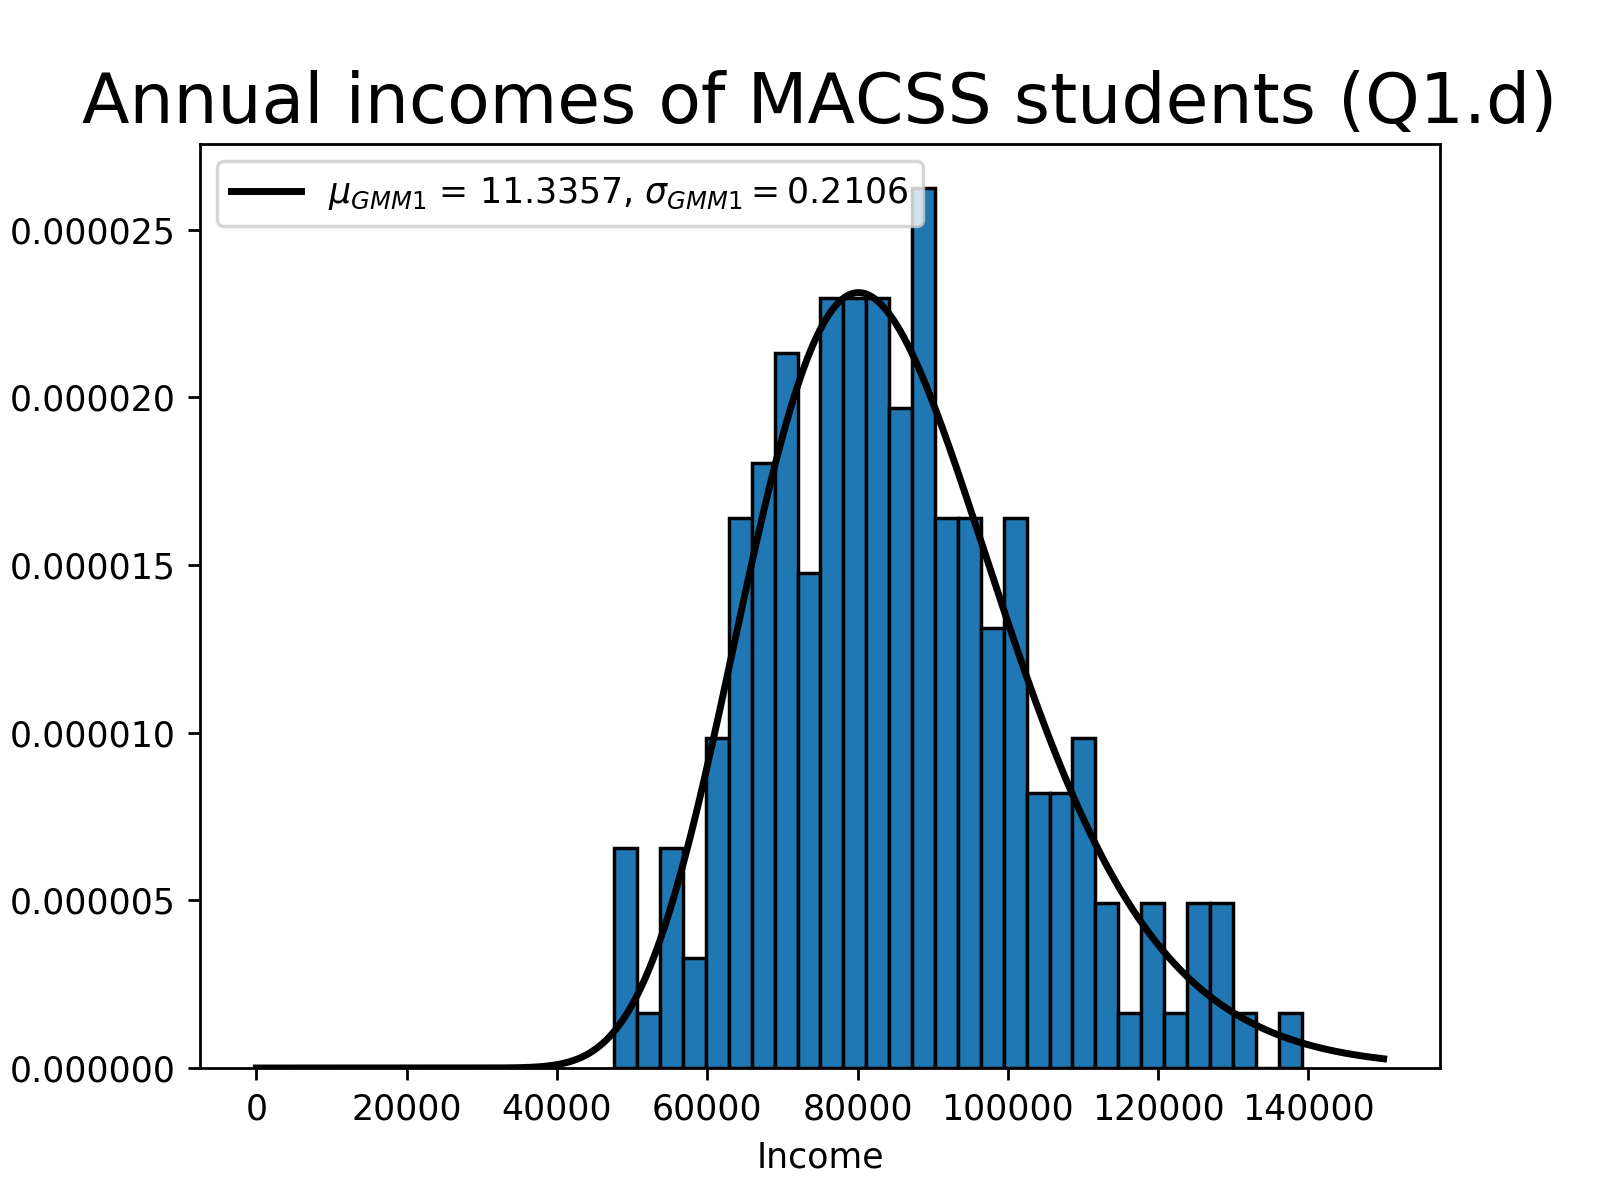

In [16]:
# Plot the histogram of the data
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Annual incomes of MACSS students (Q1.d)', fontsize=20)
plt.xlabel('Income')
plt.ylabel('Density')

# Plot the estimated GMM1 PDF
dist_pts = np.linspace(1e-10, 150000, 10000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1),linewidth=2, color='k', 
         label='$\mu_{GMM1}$ = 11.3357, $\sigma_{GMM1} = 0.2106 $')
plt.legend(loc='upper left')

plt.show()

Report the value of GMM criterion function at the estimated parameter values

In [17]:
params_GMM = np.array([mu_GMM1, sig_GMM1])
criterion_val = criterion3(params_GMM,*gmm_args)
print("The value of the criterion function is {}.".format(criterion_val[0][0]))

The value of the criterion function is 2.5077672723637038e-11.


Report and compare the two data moments against the two model moments at the estimated parameter values

In [18]:
less_75_data, less_100_data, more_100_data = data_moments3(income)
less_75_model, less_100_model, more_100_model = model_moments3(mu_GMM1, sig_GMM1)
err1 = err_vec(income, mu_GMM1, sig_GMM1, False).reshape(2,)
print('\nError vector =', err1)

print('\nData moments: ')
print('Percent of individuals who earn less than $75,000 =', less_75_data)
print('Percent of individuals who earn between $75,000 and $100,000 =', less_100_data)
print('Percent of individuals who earn more than $100,000 =', more_100_data)

print('\nModel moments: ')
print('Percent of individuals who earn less than $75,000 =', less_75_model)
print('Percent of individuals who earn between $75,000 and $100,000 =', less_100_model)
print('Percent of individuals who earn more than $100,000 =', more_100_model)


Error vector = [-0.00110349 -0.01103834]

Data moments: 
Percent of individuals who earn less than $75,000 = 0.3
Percent of individuals who earn between $75,000 and $100,000 = 0.5
Percent of individuals who earn more than $100,000 = 0.2

Model moments: 
Percent of individuals who earn less than $75,000 = 0.3000000033049511
Percent of individuals who earn between $75,000 and $100,000 = 0.5000000061504053
Percent of individuals who earn more than $100,000 = 0.1999999905446439


Comments: 
From the above results, we can see that the three data moments are really close to the three model moments. 

## Q1. (e)

In [19]:
err1 = err_vec(income, mu_GMM1, sig_GMM1, False)
VCV2 = np.dot(err1, err1.T) / income.shape[0]
print(VCV2)
W_hat2 = lin.pinv(VCV2)  
print(W_hat2)

[[  6.08847135e-09   6.09035951e-08]
 [  6.09035951e-08   6.09224825e-07]]
[[   16081.09682245   160860.83896516]
 [  160860.83896516  1609107.25171718]]


Report the estimates and criterion function value at these estimate

In [20]:
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (income, W_hat2)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results.x
print('mu_GMM2 =', mu_GMM2, ' sig_GMM2 =', sig_GMM2)

mu_GMM2 = 11.3361801068  sig_GMM2 = 0.213168732329


In [21]:
params_GMM = np.array([mu_GMM2, sig_GMM2])
criterion_val = criterion(params_GMM,*gmm_args)
print("The value of the criterion function is {}.".format(criterion_val[0][0]))

The value of the criterion function is 1.3756915846294617e-10.


Plot the estimated lognormal PDF against the histogram from part (a) and the estimated PDF from part (d)

<IPython.core.display.Javascript object>


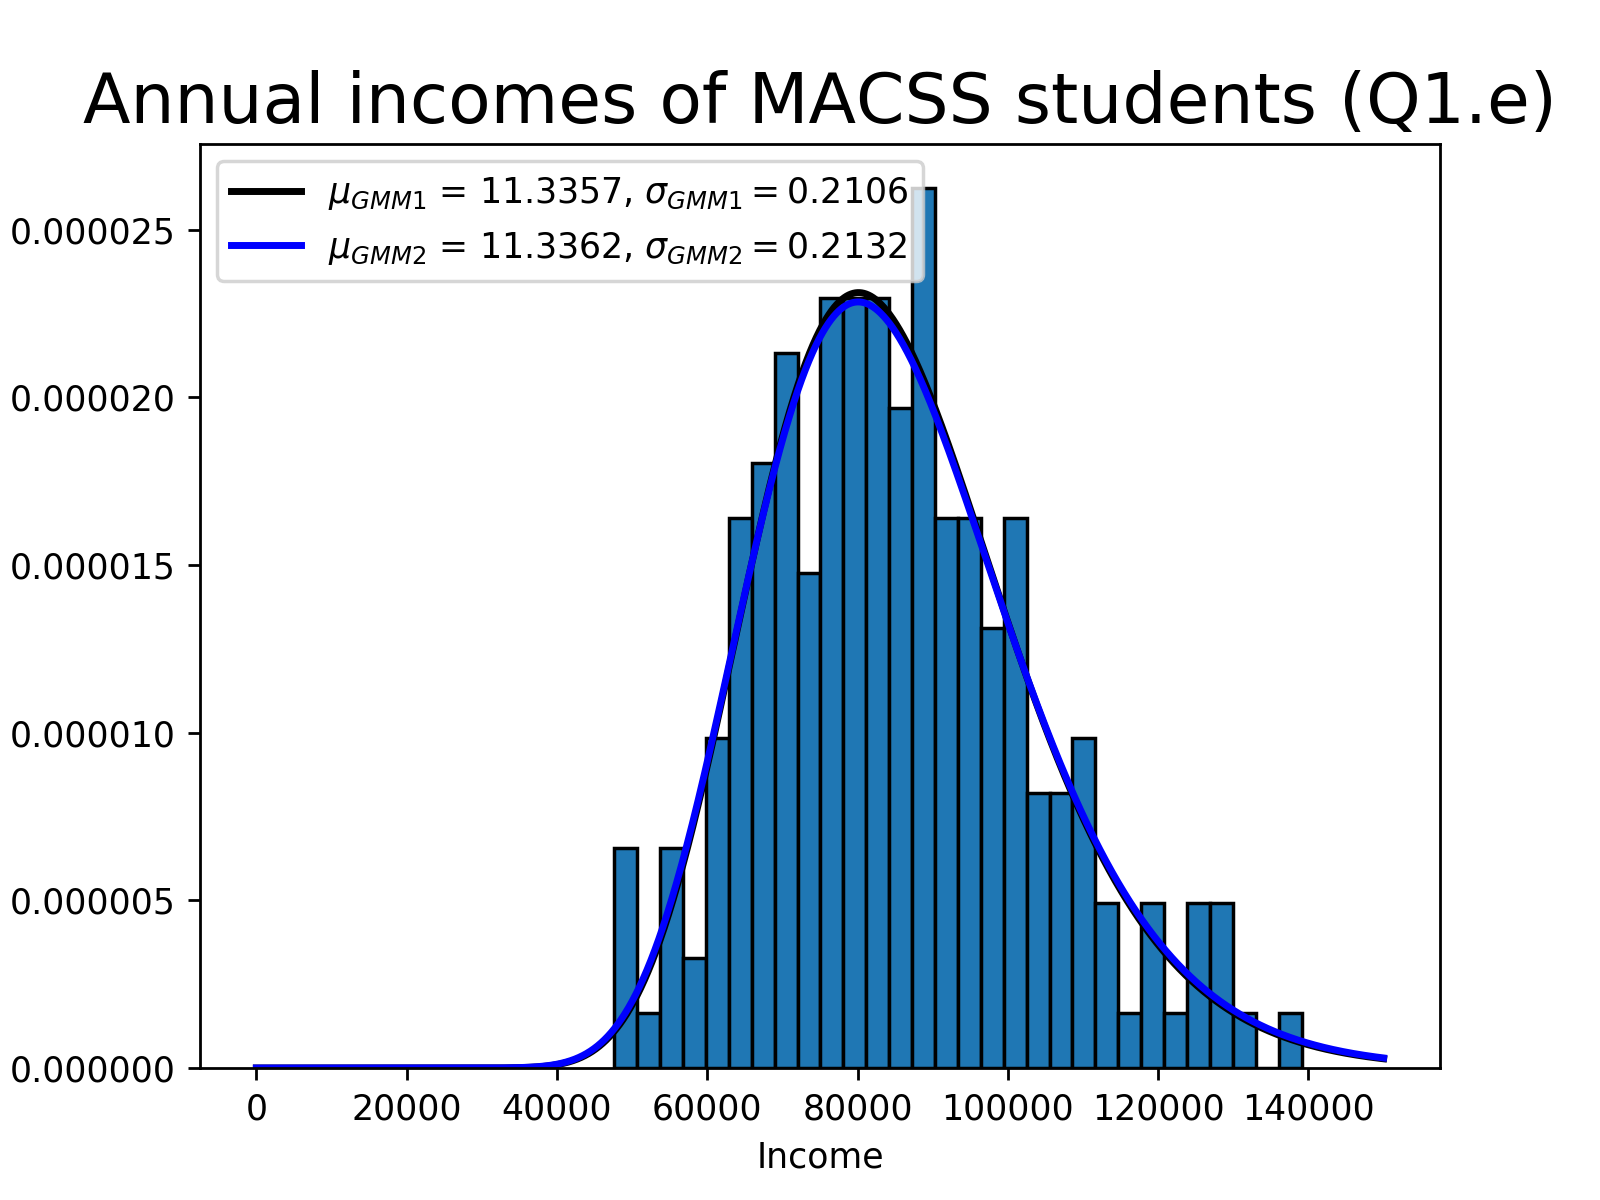

In [22]:
# Plot the histogram of the data
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Annual incomes of MACSS students (Q1.e)', fontsize=20)
plt.xlabel('Income')
plt.ylabel('Density')

# Plot the estimated GMM1 PDF
dist_pts = np.linspace(1e-10, 150000, 10000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1),linewidth=2, color='k', 
         label='$\mu_{GMM1}$ = 11.3357, $\sigma_{GMM1} = 0.2106 $')
plt.legend(loc='upper left')

# Plot the estimated GMM2 PDF
dist_pts = np.linspace(1e-10, 150000, 10000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM2, sig_GMM2),linewidth=2, color='b', 
         label='$\mu_{GMM2}$ = 11.3362, $\sigma_{GMM2} = 0.2132 $')
plt.legend(loc='upper left')

Report and compare the two data moments against the two model moments at the estimated parameter values

In [23]:
less_75_data, less_100_data, more_100_data = data_moments3(income)
less_75_model, less_100_model, more_100_model = model_moments3(mu_GMM2, sig_GMM2)
err1 = err_vec(income, mu_GMM2, sig_GMM2, False).reshape(2,)
print('Error vector =', err2)

print('\nData moments: ')
print('Percent of individuals who earn less than $75,000 =', less_75_data)
print('Percent of individuals who earn between $75,000 and $100,000 =', less_100_data)
print('Percent of individuals who earn more than $100,000 =', more_100_data)

print('\nModel moments: ')
print('Percent of individuals who earn less than $75,000 =', less_75_model)
print('Percent of individuals who earn between $75,000 and $100,000 =', less_100_model)
print('Percent of individuals who earn more than $100,000 =', more_100_model)

Error vector = [ -7.17201481e-07   1.27359042e-06]

Data moments: 
Percent of individuals who earn less than $75,000 = 0.3
Percent of individuals who earn between $75,000 and $100,000 = 0.5
Percent of individuals who earn more than $100,000 = 0.2

Model moments: 
Percent of individuals who earn less than $75,000 = 0.3013863476519972
Percent of individuals who earn between $75,000 and $100,000 = 0.49509924554506723
Percent of individuals who earn more than $100,000 = 0.20351440680293578


Comments: 
From the above results, we can see that the three data moments are really close to the three model moments. 

## Q1. (f)

The estimates from part (b), (c), (d), and (e) are quite close to each other. To be specific, all estimates of $\mu$ are around 11.33, and all the estimates of $\sigma$ are around 0.21. Therefore, from the perspective of comparing $\mu$ and $\sigma$, it is hard to tell which fits the data best. However, among these four estimation, there are big difference in the criterion function value: (b) 1.1061213081504956e-12; (c) 0.005994447716434204; (d) 2.5077672723637038e-11; (e) 1.3756915846294617e-10. Part (b) has the lowest criterion function value, so I think it may be the one which fits the data best.

## Q2.

In [24]:
import pandas as pd
sick = pd.read_csv("sick.txt")
sick.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [25]:
def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the 200 data moments for GMM.
    Treat each of the 200 values of the variable sick as your data moments. 
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    RETURNS: sick
    --------------------------------------------------------------------
    '''
    return xvals.sick


def model_moments(xvals, b0, b1, b2, b3):
    '''
    --------------------------------------------------------------------
    This function computes the 200 model moments for GMM.
    Treat the predicted or expected sick values as your model moments.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    b0     = constant term
    b1     = parameter for age
    b2     = parameter for children
    b3     = parameter for avgtemp_winter

    RETURNS: sick_hat
    --------------------------------------------------------------------
    '''
    sick_hat = b0 + b1 * xvals.age + b2 * xvals.children + \
               b3 * xvals.avgtemp_winter
    
    return sick_hat


def err_vec(xvals, b0, b1, b2, b3, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    b0     = constant term
    b1     = parameter for age
    b2     = parameter for children
    b3     = parameter for avgtemp_winter
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    sick = data_moments(xvals)
    moms_data = np.array(sick)
    sick_hat = model_moments(xvals, b0, b1, b2, b3)
    moms_model = np.array(sick_hat)
    
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (4,) vector, ([b0, b1, b2, b3])
    args   = length 2 tuple, (xvals, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (200, 1) matrix, column vector of 200 moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    b0, b1, b2, b3 = params 
    xvals, W = args
    err = err_vec(xvals, b0, b1, b2, b3, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

 Report the estimates and report the value of the GMM criterion function. 

In [26]:
b0_init = 1
b1_init = 0
b2_init = 0
b3_init = 0

params_init = np.array([b0_init, b1_init, b2_init, b3_init])
W_hat = np.eye(200)
gmm_args = (sick, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (None, None), 
                                                  (None, None), (None, None)))
b0_GMM1, b1_GMM1, b2_GMM1, b3_GMM1 = results.x
print('beta0_GMM1 =', b0_GMM1, '\nbeta1_GMM1 =', b1_GMM1,
      '\nbeta2_GMM1 =', b2_GMM1, '\nbeta3_GMM1 =', b3_GMM1)

params_GMM = np.array([b0_GMM1, b1_GMM1, b2_GMM1, b3_GMM1])
criterion_val = criterion(params_GMM,*gmm_args)
print("\nThe value of the criterion function is {}.".format(criterion_val))

beta0_GMM1 = 0.252223540915 
beta1_GMM1 = 0.0130231905884 
beta2_GMM1 = 0.399763526098 
beta3_GMM1 = -0.0100603641235

The value of the criterion function is 0.014856789587279675.
